# DAML 07 - Linear Regression

Michal Grochmal <michal.grochmal@city.ac.uk>

Let's say that we performed an collected experimental data.
This data is likely to be an insight into a process about which we want to learn.
Yet, the data is incomplete and ridden with experimental error,
making it hard to recreate the process that was measured.
In most common case we'd like to find a line $y = ax +b$ which would be
a good approximation of the process.

As a simple example we can **estimate the mean speed** on a road curve by **measuring
the position** of every car starting from the entry into the curve $(t = 0)$.
Let's say we got the following measures.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

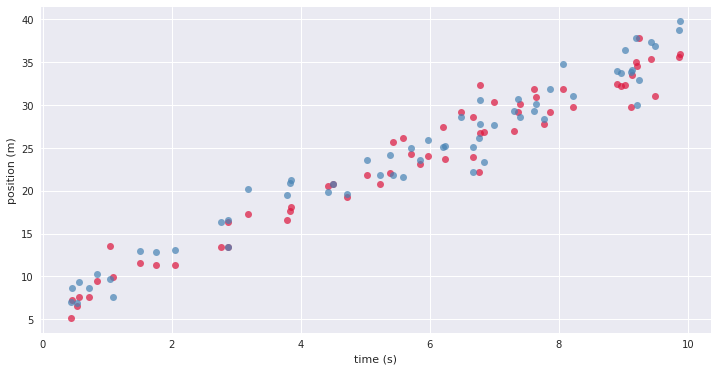

In [3]:
t = 10*np.random.rand(60)
pos1 = 7 + t*3 + 2*np.random.randn(*t.shape)
pos2 = 7 + t*3 + 2*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, pos1, 'o', color='crimson', alpha=0.7)
ax.plot(t, pos2, 'o', color='steelblue', alpha=0.7)
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)');

Least squares attempts to minimize the error (residual) across all points:

$$r = \sum_{i=1}^{N} (f(x_i) - y_i)^2 = \sum (f(\vec{X}) - \vec{y})^2$$

We can say that we are minimizing the error of the point to a function of the form:

$$y = ax + b$$

The minimization, in two dimensions, can be understood as (here $X$ and $y$ are vectors):

$$\min_{a} \|Xa - y\|$$

array([ 3.03464631])

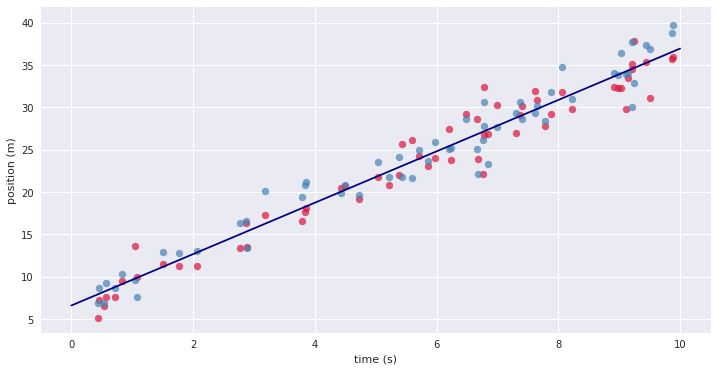

In [4]:
pos = np.hstack([pos1, pos2])
t_points = np.vstack([t[:, np.newaxis], t[:, np.newaxis]])
model = LinearRegression()
model.fit(t_points, pos)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(t, pos1, color='crimson', alpha=0.7)
ax.scatter(t, pos2, color='steelblue', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)')
model.coef_

Now we can **measure the speed** (assuming that we can compare positions very quickly,
which is what a speedometer does).  But what if we want the **typical speed at each point**
across more than just a single curve?
Let's generate some data that is akin of:

1.  Slowing down before turn.
2.  Gaining speed slowly in the turn.
3.  Gaining speed faster after exiting the curve.

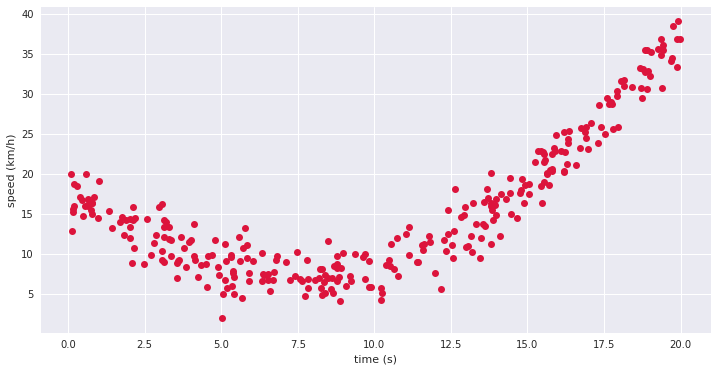

In [5]:
t = 20*np.random.rand(300)
spd = 7 + 0.2*(t-7.5)**2 + 2*np.random.randn(*t.shape)
#spd = 18 + -3*t + 0.2*t**2 + 2*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, spd, 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)');

That kind of looka like a function akin of:

$$y = a_0x^2 + a_1x + a_2$$

The traditional (read: non-computational) method to solve this problem is to get rid of $x^2$
by applying a logarithmic transformation to the axes, and then apply the linear
regression as normal since the graph would be a line.  For example:

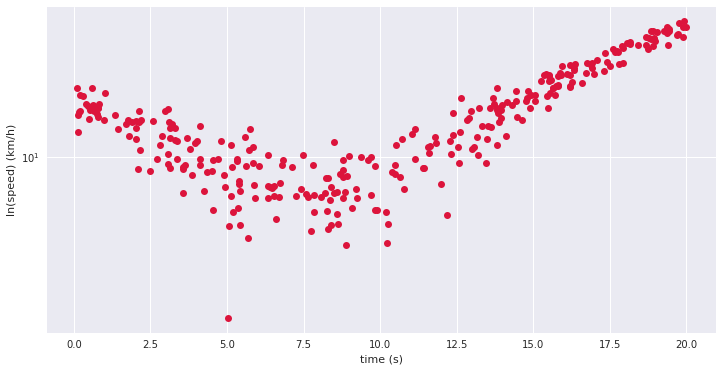

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogy(t, spd, 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('ln(speed) (km/h)');

We can now divide our data at, say, $t = 7.5$ and generate two linear regressions,
one for each side.  But there are better ways!

Since we can easily operate in more than two dimensions (time and speed inn our case)
let's build this same model in three dimensions: time, speed and speed squared.
`sklearn` provides us with `PolynomialFeatures` preprocessor for such cases.

In more dimensions we will search for more coefficients:

$$\min_{a_1, \dots, a_{d - 1}} \|Xa_j - y\|$$

Which is analogous to:

$$f(x_0, x_1, \dots, x_i) = a_0x_0 + a_1x_1 + \dots + a_ix_i + a_{i+1}$$

But nothing prevents us from doing:

$$f(x) = a_0x + a_1x^2 + a_2$$

This is still a linear model since neither $a$ parameter multiplies each other.

In [7]:
pol = PolynomialFeatures(degree=2)
pol.fit_transform(spd[:, np.newaxis])[:10, :]

array([[   1.        ,    5.37226988,   28.86128364],
       [   1.        ,   25.34487403,  642.3626394 ],
       [   1.        ,    5.98503846,   35.82068542],
       [   1.        ,   16.28453303,  265.186016  ],
       [   1.        ,   18.57680595,  345.09771929],
       [   1.        ,   19.8991905 ,  395.97778248],
       [   1.        ,   14.19997411,  201.63926466],
       [   1.        ,   29.72409159,  883.52162073],
       [   1.        ,   10.79093701,  116.44432165],
       [   1.        ,   12.28044826,  150.80940941]])

That looks good, we have a matrix of parameters for $x^0, x^1 x^2$,
now we can fit a line to that and then multiply by these parameters
again when we `perdict` the result.

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

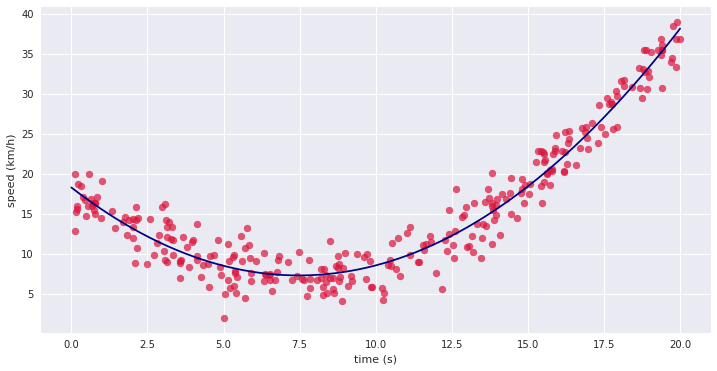

In [8]:
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 20, 2000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)')
model

In [9]:
model.named_steps.linearregression.coef_, model.named_steps.linearregression.intercept_

(array([[ 0.        , -2.93923222,  0.19660906]]), array([ 18.26919305]))

We are confident, by-eye, that our estimation is good.  Still, let's be careful and evaluate how
our model performs on unknown data (also known as *generalization*).

Each model type in `sklearn` contains a `.score()` method which contains a scoring method
appropriate for a common model of that type.  For the linear regression the scoring
is the [Coefficient of Determination (R2)][r2score]: the residual error after regression
divided by the total regression error (it is always between 0 and 1).

[r2score]: https://en.wikipedia.org/wiki/Coefficient_of_determination

In [10]:
t1, t2, s1, s2 = train_test_split(t, spd, train_size=0.7, test_size=0.3)
model.fit(t1[:, np.newaxis], s1[:, np.newaxis])
model.score(t2[:, np.newaxis], s2[:, np.newaxis])

0.95204518703317365

As we saw before, the score varies depending on how the training and test sets are selected.
Therefore we should repeat the train-test split and perform the scoring at each split.
And `sklearn` has automated that for us  with `cross_val_score`, a way of splitting data
into training and test sets in several part and then scoring each pair.  This concept
is called **cross-validation** and is prominent in all of machine learning.

In [11]:
cross_val_score(model, t[:, np.newaxis], spd[:, np.newaxis], cv=5)

array([ 0.94307363,  0.94896364,  0.93259844,  0.93380397,  0.9327506 ])

## Full road trip

Let's move forward: can we estimate the speed at each point for a longer strip of a road?
For example, some 30km of a road with turns and inclines.

For our simulation it is interesting to note that most problems in the real world are not linear,
they are either exponential or periodic.  Why?  Something, something complexity theory.
Anyway, speed on a road is a periodic problem, one speeds up and down in response
to the shape of the road he drives on.

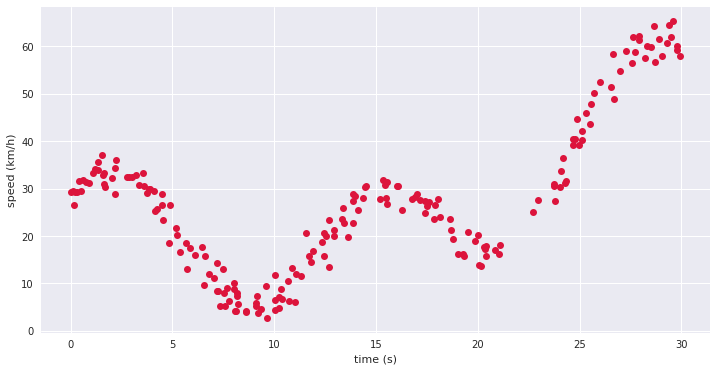

In [12]:
t = 30*np.random.rand(200)
spd = 13*np.sin(t/2) + 3.7*np.cos(t/2+7) + 3*t + 0.1*(t-10)**2 - 3*(t-3) + 7 + 2.3*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, spd, 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)');

It is pretty difficult to figure out what polynomial degree we need for this fit.
But let's try a guess, degree 7:

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

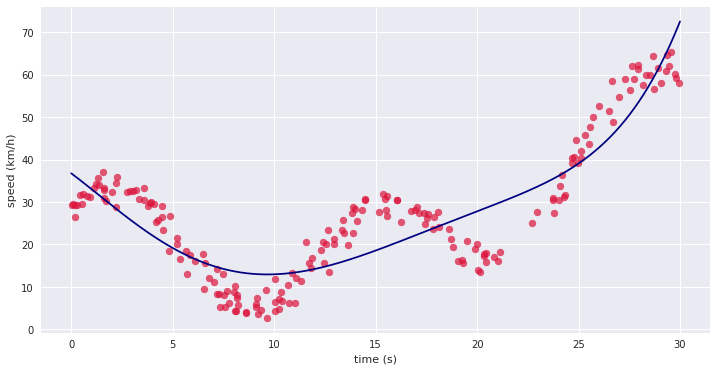

In [13]:
model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)')
model

Ouch, that went pretty badly.  This is a case where out model **underfits** the data,
i.e. our model has not enough complexity to model the complexity we see.
Let us try with a big degree, e.g. 100.

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=20, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

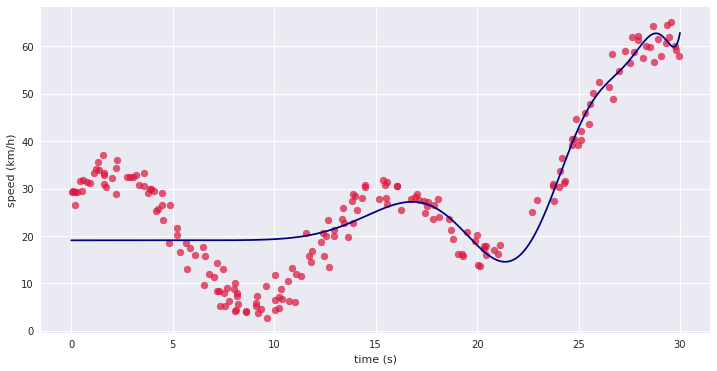

In [14]:
model = make_pipeline(PolynomialFeatures(degree=20), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)')
model

That ain't good either, we passed the point where we can bend the polynomial and
our parameters mess with each other.  The problem we see here is the the linear regression
assumes that the **variables are independent of each other**, yet $t^16$ is very
dependent on $t^2$.  To reduce this dependence a few techniques exist, these build a
**cost function** in which having many coefficients that are not zero introduces a lot of error.
Two common techniques are:

#### Ridge

$$\min_{a_1, \dots, a_{d - 1}} \|Xa_j - y\| + \alpha\|a_j\|$$

#### Lasso

$$\min_{a_1, \dots, a_{d - 1}} \frac{1}{2\cdot N_{samples}} \|Xa_j - y\| + \alpha\|a_j\|$$

Let's try it out.

/home/grochmal/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8090703240783193e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=20, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=3000,
   normalize=False, random_state=None, solver='auto', tol=0.1))])

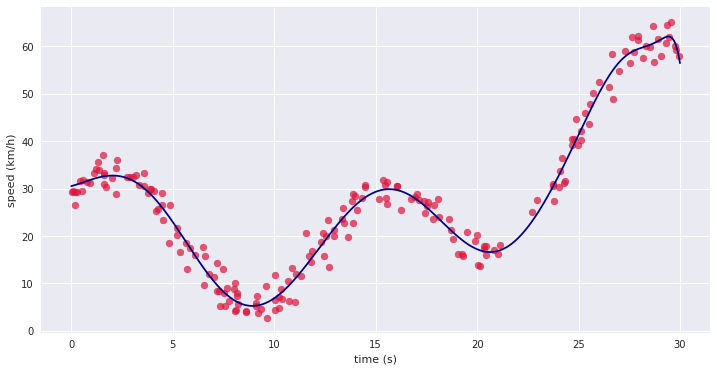

In [15]:
model = make_pipeline(PolynomialFeatures(degree=20), Ridge(alpha=10.0, tol=0.1, max_iter=3000))
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)')
model

In [16]:
import warnings
# clean output of warnings, we will root out bad fits with crossvalidation
warnings.filterwarnings('ignore', category=RuntimeWarning)
model = make_pipeline(PolynomialFeatures(degree=5), Ridge(alpha=1.0, tol=0.1, max_iter=3000))
grid = GridSearchCV(model,
                    {'polynomialfeatures__degree': list(range(5, 21)),
                     'ridge__alpha': [0.1, 0.5, 1, 2, 3, 5, 10, 20, 50, 100, 200, 300, 500]},
                    cv=5)
grid.fit(t[:, np.newaxis], spd[:, np.newaxis])
grid.best_estimator_

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=11, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=3000,
   normalize=False, random_state=None, solver='auto', tol=0.1))])

In [17]:
grid.best_score_

0.97472796674433537

And we have a quite good estimator.  Let's see how it plots over the data:

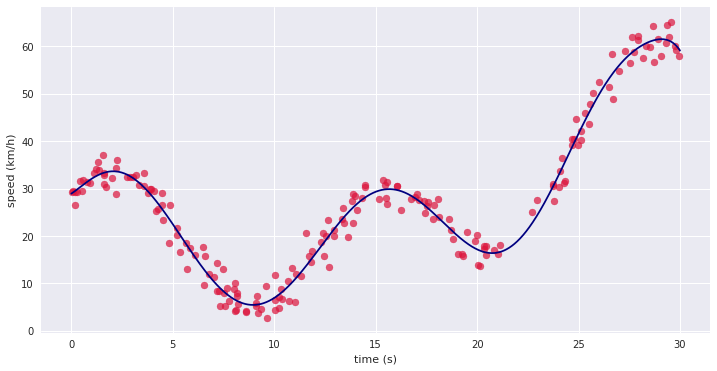

In [18]:
xfit = np.linspace(0, 30, 3000)
yfit = grid.best_estimator_.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)');

## Take home message

We managed to estimate a quite complex function.  But most importantly, we learned that we
have an arsenal of machine learning automation in `sklearn`, cross-validation and grid-search
are common to almost every machine learning problem, no matter the model used.